In [1]:
import numpy as np

# สมมติ embedding 2 vectors ขนาด 128 มิติ
embedding_a = np.random.rand(128)
embedding_b = np.random.rand(128)

# 1. Euclidean Distance เวคเตอร์เอามาลบกัน - 
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# 2. Cosine Similarity  # คำนวณ dot product แล้วหารด้วย norm ของแต่ละเวคเตอร์
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# 3. Cosine Distance = 1 - Cosine Similarity
def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)

print("Euclidean Distance:", euclidean_distance(embedding_a, embedding_b))
print("Cosine Similarity:", cosine_similarity(embedding_a, embedding_b))
print("Cosine Distance:", cosine_distance(embedding_a, embedding_b))


Euclidean Distance: 4.587368906030466
Cosine Similarity: 0.7457475723135644
Cosine Distance: 0.25425242768643563


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
import os
import cv2
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import matplotlib

#from tensorflow.keras import model


In [ ]:
from keras.models import load_model

model = load_model(r'D:\final_facenet\model\CA_076EA_078$$C078_E065.h5')
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [4]:
def Nornal(image_path):
    """
    โหลดและประมวลผลภาพอย่างปลอดภัย - แก้ไข NaN
    """
        # อ่านไฟล์
    image = tf.io.read_file(image_path)
        
        # Decode image
    image = tf.image.decode_image(image, channels=3)
        
        # แปลงเป็น float32 ก่อน resize
    image = tf.cast(image, tf.float32)
        
        # Resize
    image = tf.image.resize(image, [224, 224])
        
        # Normalize อย่างปลอดภัย
    image = (image * 255.0 - 127.5) / 128.0
        
        # ตรวจสอบค่าผิดปกติ
    #image = tf.clip_by_value(image, 0.0, 1.0)
        #print(image)
        # ตรวจสอบ NaN หรือ Inf
    #image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
        
        # กำหนด shape
    image.set_shape((224, 224, 3))

    image = tf.expand_dims(image, axis=0) # เพิ่ม batch dimension
 
    return image


In [5]:
def Nornal1(image_array):
    """
    รับ NumPy image แล้วทำ preprocessing
    """
    image = tf.convert_to_tensor(image_array, dtype=tf.float32)

    # Resize
    image = tf.image.resize(image, [224, 224])

    # Normalize: scale to [-1, 1] เช่นเดียวกับที่ใช้ใน FaceNet
    image = (image * 255.0 - 127.5) / 128.0

    # Set shape
    image.set_shape((224, 224, 3))

    # เพิ่ม batch dimension
    image = tf.expand_dims(image, axis=0)

    return image


In [6]:
def loadimagepng(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32)
        img = img / 255.0  # Normalization
        img = tf.where(tf.math.is_finite(img), img, tf.zeros_like(img)) # แทนที่ค่า NaN หรือ Inf ด้วย 0
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img
    except:
        print(f"Error loading image {image_path}. Returning a zero tensor.")
        return tf.zeros((224, 224, 3), dtype=tf.float32)

In [7]:
def loadimage(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [224, 224]) # Facenet มักใช้ 160x160 หรือ 224x224
        image = image / 255.0 # Normalize เป็น 0-1
        image = tf.clip_by_value(image, 0.0, 1.0)
        image = tf.where(tf.math.is_finite(image), image, tf.zeros_like(image))
        image.set_shape((224, 224, 3)) # กำหนด Shape ให้ชัดเจน
        return image
    except Exception as e:
        print(f"⚠️ Error loading {image_path}: {e}")
        return tf.zeros((224, 224, 3), dtype=tf.float32) # ส่งภาพดำกลับไป

In [8]:
import matplotlib.pyplot as plt


In [9]:
print("Model loaded successfully.")

Model loaded successfully.


In [10]:
detector = MTCNN()

# load the input image and convert it to grayscale
#image = cv2.imread(r'C:\InceptionNet\T1\T1.jpg') #เก็บภาพในตัวแปร ,OpenCV จะโหลดภาพมาในรูปแบบ BGR (สีน้ำเงิน, เขียว, แดง) #แสดงภาพต้นฉบับ 
def cap(image): 
    imageM = cv2.imread(image) 
    rgb_image = cv2.cvtColor(imageM, cv2.COLOR_BGR2RGB) #แปลงสีภาพจาก BGR เป็น RGB
    results = detector.detect_faces(rgb_image) #box  confidence keypoints
    for face in results:
        x, y, width, height = face['box'] #face['box'] = [100, 150, 60, 60]  x = 100, y = 150, width = 60, height = 60
        x2, y2 = x + width, y + height #  2 จุด 
        """ดึงตำแหน่งกรอบใบหน้าจาก dictionary ที่ key box
        (x, y) คือพิกัดมุมซ้ายบนของใบหน้า
        width คือความกว้างของกรอบใบหน้า
        height คือความสูงของกรอบใบหน้า"""
        # วาดกรอบสีเขียวรอบใบหน้า
        #cv2.rectangle(imageM, (x, y), (x2, y2), (0, 255, 0), 2) #cv2.rectangle(image, pt1, pt2, color, thickness)
        
        i = rgb_image[y:y2, x:x2]

        
        
        return i





In [19]:
Image1 = r'D:\final_facenet\Dataset\T1\f.jpg'
Image2 = r'D:\final_facenet\Dataset\t2\T1.jpg'
Image1c = cap(Image1)
Image2c = cap(Image2)
print("Image1c:", Image1c.shape)
print("Image1c:", Image2c.shape)

1/1 [==============================] - 0s 90ms/step
Image1c: (364, 312, 3)
Image1c: (319, 247, 3)


In [24]:
nor1 = Nornal1(Image1c)
em1 = model.predict(nor1)

nor2 = Nornal1(Image2c)
em2 = model.predict(nor2)


print("Embedding vector:", em1)
print("Embedding vector:", em2)

print(em1.shape)
print(em2.shape)
print(nor1.shape)
print(nor2.shape)

#print("Embedding vector:", em2)

1/1 [==============================] - 0s 60ms/step
Embedding vector: [[ 0.03281095  0.11439434  0.12510589 -0.11335942  0.06292529  0.00626869
  -0.09530554 -0.00245133  0.07948326  0.00191315  0.02356771  0.07297853
  -0.05347884  0.00336    -0.01117778  0.10235891 -0.07118771  0.00229836
  -0.0279574  -0.111145   -0.1256114   0.05167749 -0.02190211 -0.13978407
   0.03622589 -0.1120075   0.19444518  0.00848946 -0.0641242   0.0942153
  -0.01553095  0.2229738   0.02344895 -0.03496     0.09892997  0.08276176
   0.05625145  0.0739427   0.09905226 -0.065453    0.09112488 -0.07258228
   0.02557733  0.00907285 -0.01048791  0.08416244 -0.03114403  0.16086043
   0.05574096  0.13385282  0.05732825 -0.00598539  0.04571439 -0.04167604
   0.05547885  0.0330447  -0.14876539  0.03138171 -0.12627327 -0.03799503
  -0.02825542  0.07955667  0.1782842  -0.11176239  0.04258565 -0.03727843
  -0.07565692 -0.05408227 -0.07003129 -0.25790393 -0.02492788  0.111894
  -0.1104615  -0.08251926 -0.11361371 -0.0587

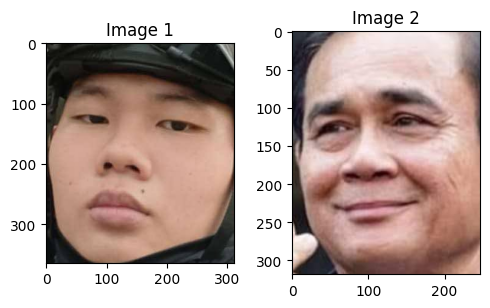

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))  # ขนาดหน้าต่างรวม

# แสดงภาพแรก
plt.subplot(1, 2, 1)  # 1 แถว 2 คอลัมน์, ภาพที่ 1
plt.imshow(Image1c)
plt.title("Image 1")
#plt.axis('off')

# แสดงภาพที่สอง
plt.subplot(1, 2, 2)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(Image2c)
plt.title("Image 2")

plt.tight_layout()
plt.show()


#image_np1 = Image1.numpy()[0]
#image_np2 = Image2.numpy()[0]


In [25]:
import numpy as np

# สมมติ embedding 2 vectors ขนาด 128 มิติ
embedding_a = em1[0]  # แปลงเป็นเวกเตอร์ 1 มิติ
embedding_b = em2[0]  # แปลงเป็นเวกเตอร์ 1 มิติ

# 1. Euclidean Distance เวคเตอร์เอามาลบกัน - 
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# 2. Cosine Similarity  # คำนวณ dot product แล้วหารด้วย norm ของแต่ละเวคเตอร์
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# 3. Cosine Distance = 1 - Cosine Similarity
def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)


eu_dist = euclidean_distance(embedding_a, embedding_b)
cos_sim = cosine_similarity(embedding_a, embedding_b)
cos_dist = cosine_distance(embedding_a, embedding_b)

print("Euclidean Distance:", eu_dist)
print("Cosine Similarity:", cos_sim)
print("Cosine Distance:", cos_dist)
 
# เพิ่มเงื่อนไขตรวจสอบความเหมือนของใบหน้า
if eu_dist < 0.2:
    print("เหมือน")
else:
    print("ไม่เหมือน")

Euclidean Distance: 0.042982005
Cosine Similarity: 0.9990762
Cosine Distance: 0.0009238123893737793
เหมือน


In [16]:
imaeda = cv2.imread(r'C:\InceptionNet\datasettest\train\359219\17062613.jpg')
imaedb = cv2.imread(r"C:\InceptionNet\Cropface\test\24\1414.jpg_face_1.jpg")

ima112 = cv2.imread(r"C:\InceptionNet\datasettest\train\24\1408.jpg")

In [18]:
import cv2
resized_img = cv2.resize(imaeda, (224, 224))
resized_imgC = cv2.resize(imaedb, (224, 224))
resized_img112 = cv2.resize(ima112, (224, 224))

print(resized_img.shape)
print(resized_imgC.shape)
print("1212*1212",resized_img112.shape)

(224, 224, 3)
(224, 224, 3)
1212*1212 (224, 224, 3)


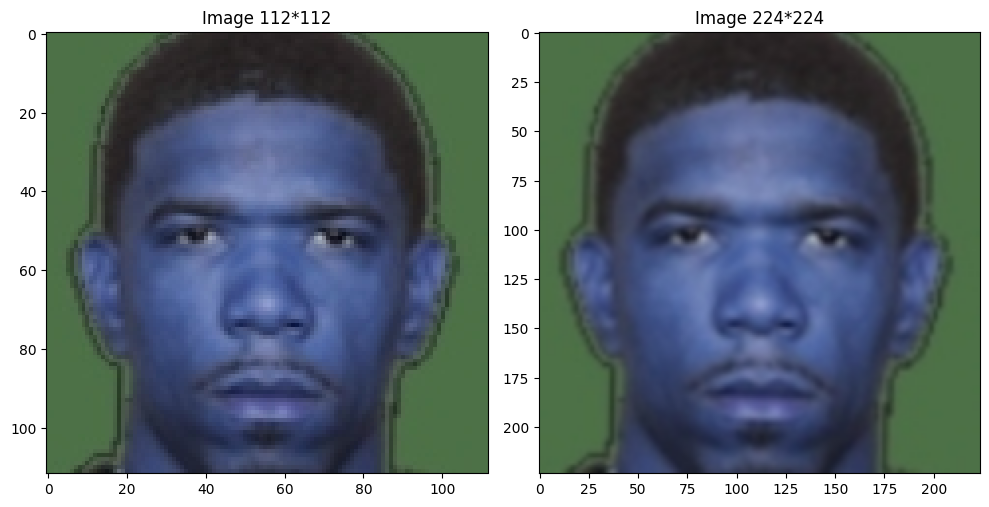

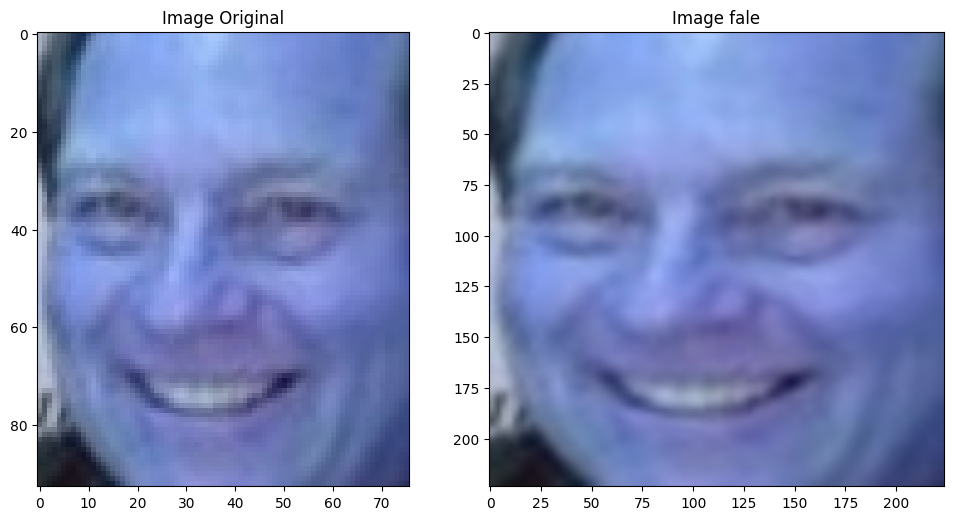

Text(0.5, 1.0, 'Image Original')

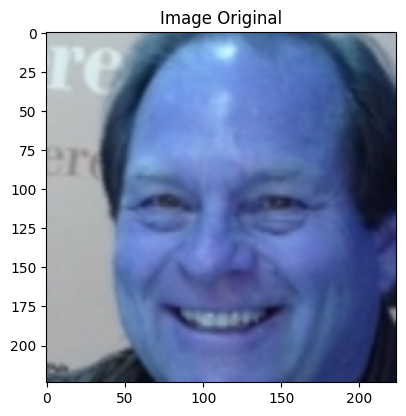

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)  # 1 แถว 2 คอลัมน์, ภาพที่ 1
plt.imshow(imaeda)
plt.title("Image 112*112")
#plt.axis('off')

# แสดงภาพที่สอง
plt.subplot(1, 2, 2)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(resized_img)
plt.title("Image 224*224")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(imaedb)
plt.title("Image Original")

plt.subplot(2, 2, 2)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(resized_imgC)
plt.title("Image fale")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 1 แถว 2 คอลัมน์, ภาพที่ 2
plt.imshow(resized_img112)
plt.title("Image Original")



In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# โหลดโมเดล FaceNet
model = tf.keras.models.load_model(r'C:\InceptionNet\inception+loss\modelA2.10.keras')

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    return np.expand_dims(image, axis=0)

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def load_embeddings_from_folder(folder_path):
    embeddings_dict = {}  # {class_name: [embedding1, embedding2, ...]}
    class_names = sorted(os.listdir(folder_path))
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        embeddings = []
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            img_path = os.path.join(class_path, img_name)
            img = preprocess_image(img_path)
            emb = model.predict(img)
            embeddings.append(emb)
        embeddings_dict[class_name] = embeddings
    return embeddings_dict

# โหลด embeddings ทั้ง train และ test
train_embeddings = load_embeddings_from_folder(r"C:\InceptionNet\mediamdata")
test_embeddings = load_embeddings_from_folder(r"C:\InceptionNet\matatestmediam")

# คำนวณระยะ Euclidean ระหว่างทุกคู่ของ train & test
threshold = 0.9
correct = 0
total = 0
distances = []

for class_name in test_embeddings:
    test_emb_list = test_embeddings[class_name]
    train_emb_list = train_embeddings.get(class_name, [])
    for idx_test, test_emb in enumerate(test_emb_list):
        matched = False
        for idx_train, train_emb in enumerate(train_emb_list):
            dist = euclidean_distance(test_emb, train_emb)
            distances.append(dist)
            total += 1
            is_same = dist < threshold
            print(f"[Class: {class_name}] Test image #{idx_test+1} vs Train image #{idx_train+1} --> Distance: {dist:.4f} --> {'เหมือน' if is_same else 'ไม่เหมือน'}")
            if is_same:
                matched = True
        if matched:
            correct += 1

accuracy = correct / total if total > 0 else 0
print(f"✅ Accuracy: {accuracy:.4f} ({correct}/{total})")


plt.figure(figsize=(8,4))
plt.hist(distances, bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Distribution of Euclidean Distances")
plt.xlabel("Distance")
plt.ylabel("Number of pairs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 133ms/step


เหมือน


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# โหลดโมเดล FaceNet
model = tf.keras.models.load_model('/code/modelA2.10.keras')

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    return np.expand_dims(image, axis=0)

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def load_embeddings_from_folder(folder_path, img_index=0):
    embeddings_dict = {}
    class_names = sorted(os.listdir(folder_path))
    total_classes = len(class_names)

    for idx, class_name in enumerate(class_names, start=1):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"\n📁 [Class {idx}/{total_classes}] {class_name}")

        img_files = sorted([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        # ✅ ตรวจสอบว่ามีรูปมากกว่า 2
        if len(img_files) < 2:
            print(f"  ⚠️ ข้ามคลาสนี้ เพราะมีรูปแค่ {len(img_files)} รูป (ต้องมากกว่า 2)")
            continue

        # ✅ ตรวจว่ามีรูปตาม index ที่ขอไว้
        if len(img_files) <= img_index:
            print(f"  ❌ ไม่มีรูปที่ {img_index+1} ในคลาสนี้")
            continue

        img_path = os.path.join(class_path, img_files[img_index])
        img = preprocess_image(img_path)
        emb = model.predict(img, verbose=0)
        embeddings_dict[class_name] = [emb]

        print(f"  ✅ [{img_index+1}/{len(img_files)}] {img_files[img_index]} → embedding สร้างแล้ว")

    print("\n✅ เสร็จสิ้นการสร้าง embeddings ทั้งหมด\n")
    return embeddings_dict



# โหลด embeddings ทั้ง train และ test
train_embeddings = load_embeddings_from_folder("/data", img_index=0)  # ใช้รูปแรกของแต่ละคลาสใน train
test_embeddings = load_embeddings_from_folder("/data", img_index=1)    # ใช้รูปที่สองของแต่ละคลาสใน test

# คำนวณ Euclidean ระหว่าง embeddings ของ train & test
threshold = 0.9
correct = 0
total = 0
distances = []

for class_name in test_embeddings:
    test_emb_list = test_embeddings[class_name]
    train_emb_list = train_embeddings.get(class_name, [])

    if not test_emb_list or not train_emb_list:
        continue

    test_emb = test_emb_list[0]
    train_emb = train_emb_list[0]

    dist = euclidean_distance(test_emb, train_emb)
    distances.append(dist)
    total += 1
    is_same = dist < threshold

    print(f"[Class: {class_name}] Distance: {dist:.4f} --> {'เหมือน' if is_same else 'ไม่เหมือน'}")

    if is_same:
        correct += 1

accuracy = correct / total if total > 0 else 0
print(f"\n✅ Accuracy: {accuracy:.4f} ({correct}/{total})")

# วาดกราฟ histogram
plt.figure(figsize=(8, 4))
plt.hist(distances, bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Distribution of Euclidean Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ไม่เหมือน